In [ ]:
import Pkg; Pkg.add("Distributions")
Pkg.add("Random")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("PyPlot")
Pkg.add("Polynomials")

# Basic simulation - Call Gapping

In [3]:
using Distributions, Random

function simTau(N,tau,lambda,mu,c,tMax, seed = 1974)
    Random.seed!(seed)
    state = [0 for _ in 1:N]
    currentArm = 1
    allowedToSwitch = false
    t = 0.0
    reward = 0.0

    megaValue = 0.0
    
    rLam() = rand(Exponential(1/lambda))
    rMu() = rand(Exponential(1/mu))
    nextArm(i) = (i%N)+1

    #N+1 event types in this discrete event simulation
    timeJumps = [rLam() for _ in 1:N] 
    push!(timeJumps,tau) #The last one is for the call gapping

    #debug
    regCycles = []
    prevRegTime = 0.0

    #debug
    switchCounts =[]
    switchCounter = 0

    #debug
    timeInOne = zeros(N)
    
    #debug
    timeOfLastSwitchToBadArm = Inf
    w0Cycles = []
    
    while t<tMax
       tLast = t 
       t,i = findmin(timeJumps)
       reward += state[currentArm]*(t-tLast)

       timeInOne += (t-tLast)*state[1:N]
        
       megaValue += (t-tLast)*sum(state) 
        
       if i == N+1 #call gapping timer up
            #println("$(t),$(currentArm): gap reached")
            if state[currentArm] == 0
                #println("$(t),$(currentArm): switching from $(currentArm)")
                switchCounter += 1
                if timeOfLastSwitchToBadArm != Inf
                       push!(w0Cycles,t-timeOfLastSwitchToBadArm)
                       timeOfLastSwitchToBadArm = Inf
                end
                if(state[nextArm(currentArm)] == 0)
                   timeOfLastSwitchToBadArm = t 
                   push!(regCycles,t-prevRegTime) 
                    prevRegTime = t
                    push!(switchCounts,switchCounter-1)
                    switchCounter = 0
                end
                currentArm = nextArm(currentArm)
                allowedToSwitch = false
                timeJumps[N+1] = t+tau
                reward -= c
            else
                allowedToSwitch = true
                timeJumps[N+1] = Inf
            end
        else #arm changing state
           if state[i] == 0
              #println("$(t),$(currentArm): Arm $(i) switch to 1")  
              state[i] = 1
              timeJumps[i] = t+rMu()
           else #state was 1
               #println("$(t),$(currentArm): Arm $(i) switch to 0")  
               state[i] = 0
               timeJumps[i] = t+rLam()
               if allowedToSwitch && state[currentArm] == 0
                    #println("$(t),$(currentArm): switching from $(currentArm)")
                    switchCounter += 1
                    if timeOfLastSwitchToBadArm != Inf
                       push!(w0Cycles,t-timeOfLastSwitchToBadArm)
                       timeOfLastSwitchToBadArm = Inf
                    end
                    if(state[nextArm(currentArm)] == 0)
                       timeOfLastSwitchToBadArm = t 
                       push!(regCycles,t-prevRegTime) 
                        prevRegTime = t
                        push!(switchCounts,switchCounter-1)
                        switchCounter = 0
                    end
                    currentArm = nextArm(currentArm)
                    allowedToSwitch = false
                    timeJumps[N+1] = t+tau
                    reward -= c
               end
           end
       end
    end

    #println("mean of switch counts: ",mean(switchCounts))
    halfIndex = Int(round(length(regCycles)/2))
    #println("mean of reg cycles: ",mean(regCycles[halfIndex:length(regCycles)]))
    
    #println("mean of W0: ", mean(w0Cycles))
    #println("timeInOne(32): ", timeInOne[32]/tMax)
    
    #println("megaValue: ", megaValue/(tMax*N))
    
    #regCycles
    reward/tMax
end

simTau (generic function with 2 methods)

In [ ]:
simTau(5,0.99,0.5,1,0.2,10^5)

# Basic simulation - Belief Threshold

In [4]:
using Distributions, Random

function simOmega(N,ω,lambda,mu,c,tMax, seed = 1974)
    Random.seed!(seed)
    state = [0 for _ in 1:N] #actual state of arms
    allowedToSwitchTo = [true for _ in 1:N] #state of belief state of arms (true => passed the threshold)
    currentArm = 1
    t = 0.0
    reward = 0.0
    γ = lambda/(lambda+mu)
    ω >= γ && error("ω is too big")
    implicitTau = -γ*log(1-ω/γ)

    megaValue = 0.0
    
    rLam() = rand(Exponential(1/lambda))
    rMu() = rand(Exponential(1/mu))
    nextArm(i) = (i%N)+1
    
    #2N event types in this discrete event simulation
    timeJumps = [rLam() for _ in 1:N] #first N events are for state change
    append!(timeJumps,fill(implicitTau,N)) #initilize N events for "ok to switch to arm"
    timeJumps[currentArm + N] = Inf
        
    #assumes the currentArm is bad (in 0) and searches for a better arm afterwards
    function searchForNextArm()
        na = nextArm(currentArm)
        for _ in 1:N-1 #loop untill either (1) found a good arm (2) no where to switch to
            if allowedToSwitchTo[na] #if allowed to switch - lets do it
                timeJumps[currentArm + N] = t + implicitTau #leaving arm so set the belief update
                allowedToSwitchTo[currentArm] = false
                currentArm = na
                reward -= c
               # @show timeJumps
                if state[currentArm] == 1 #we are happy and leave
                    break
                end
            end
            na = nextArm(na)
        end
        timeJumps[currentArm + N] = Inf
    end
    
    while t<tMax
       tLast = t 
       t,i = findmin(timeJumps)
       reward += state[currentArm]*(t-tLast)
        if i >= N+1 #pass the omega threshold event
            allowedToSwitchTo[i-N] = true 
            if state[currentArm] == 0
                searchForNextArm()
            else
                timeJumps[i] = Inf
            end
        else #arm i is changing state event
           if state[i] == 0
              state[i] = 1
              timeJumps[i] = t + rMu()
           else #state was 1
                state[i] = 0
                timeJumps[i] = t + rLam()
                if allowedToSwitchTo[nextArm(currentArm)] && state[currentArm] == 0
                    searchForNextArm()
                end
           end
       end
    end

    reward/tMax
end

simOmega (generic function with 2 methods)

In [ ]:
simOmega(5,0.333,0.5,1,0.2,10^5)

In [ ]:
simOmega(2,0.3,1,1/0.4-1,0.005,10^4)

## case I (full observation)

In [3]:
function caseIg(n,gamma,c)
    if c > gamma
        gamma
    else
        1-(1-gamma).^n-c.*(1-gamma-(1-gamma).^n)/gamma
    end
end

caseIg (generic function with 1 method)

## case II (partial observation ∞)

In [6]:
function caseIIgInfty(gamma,c)
    if c > gamma^2
        gamma
    else
        1- c.*(1-gamma)/gamma.^2
    end
end

caseIIgInfty (generic function with 1 method)

In [27]:
gamma = 0.4;
lambda = 1; mu = 1/gamma - 1;
tMax = 10^5

tauGrid = union(0.001:0.001:1.55,Inf)
cGrid = union(0.001:0.005:0.16)
# cGrid = union(0.001:0.005:0.195)
# cGrid = union(0.001:0.005:0.195, 0.2:0.001:0.5)
# nGrid = [2,3,4,20] 
nGrid = [2,3,4] 
# nGrid = 20

g_star = zeros(length(nGrid),length(cGrid))
index_star = zeros(length(nGrid),length(cGrid))

g_star_caseI = zeros(length(nGrid),length(cGrid))

for (ni,nn) in enumerate(nGrid)
    println("nn = $nn")
    for (ci,c) in enumerate(cGrid)
        vals = [simTau(nn,tau,lambda,mu,c,tMax) for tau in tauGrid]
        g, i = findmax(vals)
        #####################
        # function sim_g_tau(tau)
        #    y = -sim(nn,tau,lambda,mu,c,tMax)
        #    return y
        # end
        # tau, g = searchMax(sim_g_tau)
        # g = max(g, sim(nn,Inf,lambda,mu,c,tMax))
        #####################
        # println("c = $(c) \t g = $(g) \t tau = $(tau)")
        # println("c = $(c) \t g = $(g) \t tau = $(tauGrid[i])")
        g_star[ni,ci] = g
        index_star[ni,ci] = i
        g_star_caseI[ni,ci] = caseIg(nn,gamma,c) 
    end
end

nn = 2
nn = 3
nn = 4


In [18]:
g_star[1,3]

0.5784375034845015

In [19]:
gamma = 0.4;
lambda = 1; mu = 1/gamma - 1;
tMax = 10^5

OmegaGrid = union(0.001:0.001:gamma-0.005)
cGrid = union(0.001:0.005:0.16)
# cGrid = union(0.001:0.005:0.195, 0.2:0.001:0.5)
# nGrid = [2,3,4,20] 
nGrid = [2,3,4] 
# nGrid = 20

g_star_caseII_omega = zeros(length(nGrid),length(cGrid))
index_star_caseII_omega = zeros(length(nGrid),length(cGrid))

for (ni,nn) in enumerate(nGrid)
    println("nn = $nn")
    for (ci,c) in enumerate(cGrid)
        vals = [simOmega(nn,ω,lambda,mu,c,tMax) for ω in OmegaGrid]
        g, i = findmax(vals)
        g_star_caseII_omega[ni,ci] = g
        index_star_caseII_omega[ni,ci] = i
    end
end

nn = 2
nn = 3
nn = 4


### Saving the simulation results in file

In [ ]:
cGrid = union(0.001:0.005:0.195, 0.2:0.001:0.5);
cGrid = union(0, cGrid);
caseIg_0 = [caseIg(nn,gamma,0) for nn in nGrid]
g_star = hcat(caseIg_0,g_star)
g_star_caseI = hcat(caseIg_0,g_star_caseI)

In [ ]:
outFile = open("gStarDataCase20II.jl","w")

# Maybe also save the gamma and other stuff in the fi

println(outFile,"cGrid = $cGrid")
println(outFile,"nGrid = $nGrid")
println(outFile,"g_star_20 = $g_star")
println(outFile,"g_star_caseI_20 = $g_star_caseI")
close(outFile)

In [ ]:
outFile = open("gStarOmegaCaseII.jl","w")

# Maybe also save the gamma and other stuff in the fi

println(outFile,"cGrid = $cGrid")
println(outFile,"nGrid = $nGrid")
println(outFile,"g_star_omega = $g_star_caseII_omega")
close(outFile)

In [ ]:
outFile = open("gStarDataCase.jl","w")

# Maybe also save the gamma and other stuff in the fi

println(outFile,"cGrid = $cGrid")
println(outFile,"nGrid = $nGrid")
println(outFile,"g_star_20 = $g_star")
println(outFile,"g_star_caseI_20 = $g_star_caseI")
close(outFile)

In [23]:
outFile = open("giStarOmegaCaseII.jl","w")

# Maybe also save the gamma and other stuff in the fi

println(outFile,"cGrid = $cGrid")
println(outFile,"nGrid = $nGrid")
println(outFile,"g_star_omega = $g_star_caseII_omega")
println(outFile,"index_star_caseII_omega = $index_star_caseII_omega")
close(outFile)

In [28]:
outFile = open("giStarTauCaseII.jl","w")

# Maybe also save the gamma and other stuff in the fi

println(outFile,"cGrid = $cGrid")
println(outFile,"nGrid = $nGrid")
println(outFile,"g_star = $g_star")
println(outFile,"index_star = $index_star")
close(outFile)

## Plots of case I and II for $n = 2,3,4,20$

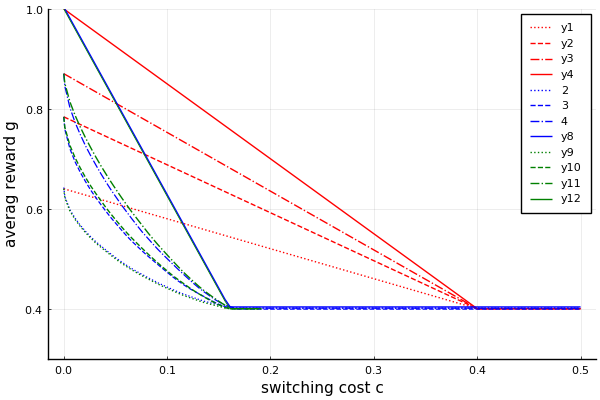

In [51]:
using Plots, LaTeXStrings; pyplot()
gamma = 0.4;
include("gStarDataCaseI&II.jl")
#plot(cGrid, g_star_caseI', label = hcat(nGrid...), c = [:magenta :magenta :magenta :magenta],linestyle=[:dash :solid :dashdot],
#    ylim = (0.3,1),xlabel = "c", ylabel = "g")
plot(cGrid, g_star_caseI', c = [:red :red :red :red],linestyle=[:dot :dash :dashdot],
    ylim = (0.3,1),xlabel = "switching cost c", ylabel = "averag reward g")
caseIgInf = [caseIg(100,gamma,c) for c in cGrid];
#plot!(cGrid,caseIgInf,label="∞",c = :magenta, linestyle = :dot,
#    ylim = (0.3,1))
plot!(cGrid,caseIgInf, c = :red, linestyle = :solid,
    ylim = (0.3,1))
############################
gSize = size(g_star)
plot!(cGrid,g_star'+[ones(1, gSize[2])*0.0025; zeros(2,gSize[2])]',label = hcat(nGrid...),c = [:blue :blue :blue], linestyle=[:dot :dash :dashdot],
    linewidth = 0.9, ylim = (0.3,1))
caseIIgInf = [caseIIgInfty(gamma,c) for c in cGrid];
#plot!(cGrid,caseIIgInf,label="∞",c = :blue, linestyle = :dot,
#    ylim = (0.3,1))
plot!(cGrid,caseIIgInf.+0.0035,c = :blue, linestyle = :solid,
    ylim = (0.3,1))
############################
include("gStarOmegaCaseII.jl")
cGrid = union(0, cGrid); 
caseIg_0 = [caseIg(nn,gamma,0) for nn in nGrid]
g_star_omega = hcat(caseIg_0,g_star_omega)
sIndex = findall(g_star_omega.< gamma);
g_star_omega[sIndex] = [gamma for i in 1:length(sIndex)];
#plot!(cGrid,g_star_omega',label = hcat(nGrid...),c = [:cyan :cyan :cyan], linestyle=[:dot :dash :dashdot],
#    ylim = (0.3,1))
plot!(cGrid,g_star_omega',c = [:green :green :green], linestyle=[:dot :dash :dashdot],
    ylim = (0.3,1))
caseIIgInf = [caseIIgInfty(gamma,c) for c in cGrid];
#plot!(cGrid,caseIIgInf,label="∞",c = :cyan, linestyle = :dot,
#   ylim = (0.3,1))
plot!(cGrid,caseIIgInf,c = :green, linestyle = :solid, linewidth = 0.6,
   ylim = (0.3,1))

In [52]:
savefig("gAsFunctionOfCMultiple.pdf")

In [4]:
using Plots, LaTeXStrings; pyplot()
delta = 0.001;
include("giStarTauCaseII.jl")
plot(cGrid, index_star'.*delta', label = "call gapping", c = [:blue :blue :blue], linestyle=[:dot :dash :dashdot],
    ylim = (0,2),xlabel = "c", ylabel = "τ")
include("giStarOmegaCaseII.jl")
σ = -gamma.*log.(1 .- (index_star_caseII_omega.*delta)./gamma);
plot!(cGrid, σ', label = "cool off", c = [:cyan :cyan :cyan], linestyle=[:dot :dash :dashdot],
    ylim = (0,2),xlabel = "c", ylabel = "τ")

ErrorException: could not open file /Users/jiesenw/Dropbox/1 Peter/assorted/untitled folder/ChannelSelection/giStarTauCaseII.jl

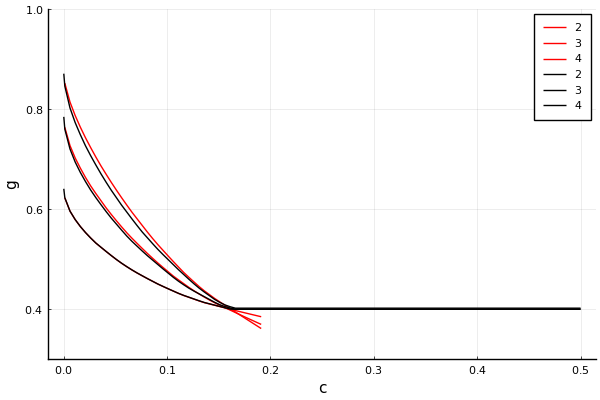

In [8]:
using Plots, LaTeXStrings; pyplot()

#This is the plot of case II (other channels not observable)""
include("gStarOmegaCaseII.jl")
plot(cGrid, g_star_omega', label = hcat(nGrid...), c = [:red :red :red :red],
    ylim = (0.3,1),xlabel = "c", ylabel = "g")
include("gStarDataCaseI&II.jl")
plot!(cGrid, g_star', label = hcat(nGrid...), c = [:black :black :black :black],
    ylim = (0.3,1),xlabel = "c", ylabel = "g")

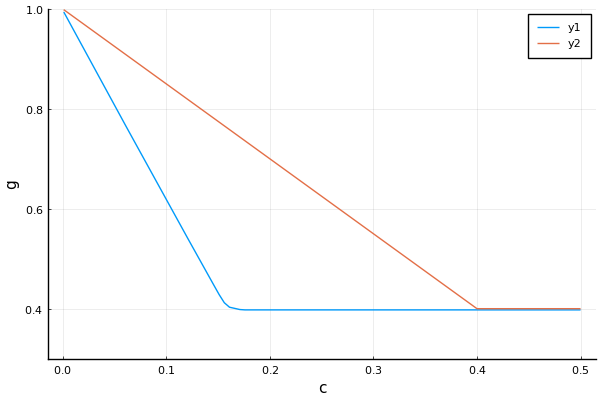

In [71]:
using Plots, LaTeXStrings; pyplot()

#This is the plot of case II (other channels not observable)""
include("gStarDataCase20II.jl")
plot(cGrid, g_star_20', ylim = (0.3,1),xlabel = "c", ylabel = "g")
#This is the plot of case I (both channels are observable)
plot!(cGrid,g_star_caseI_20')

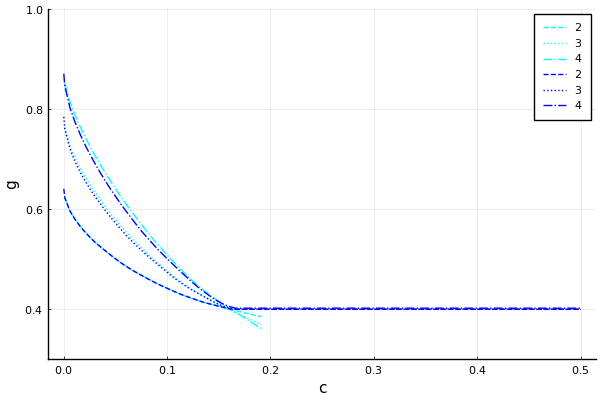

In [11]:
using Plots, LaTeXStrings; pyplot()

#This is the plot of case II (other channels not observable)""
include("gStarOmegaCaseII.jl")
plot(cGrid, g_star_omega', label = hcat(nGrid...),c = [:cyan :cyan :cyan :cyan],linestyle=[:dash :dot :dashdot :dashdotdot],
    ylim = (0.3,1),xlabel = "c", ylabel = "g")
include("gStarDataCaseI&II.jl")
plot!(cGrid, g_star', label = hcat(nGrid...),c = [:blue :blue :blue :blue],linestyle=[:dash :dot :dashdot :dashdotdot],
    ylim = (0.3,1),xlabel = "c", ylabel = "g")

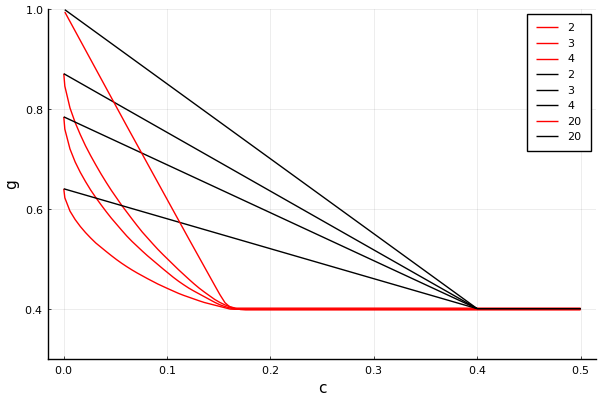

In [72]:
using Plots, LaTeXStrings; pyplot()

#This is the plot of case II (other channels not observable)""
include("gStarDataCaseI&II.jl")
plot(cGrid, g_star', label = hcat(nGrid...), c = [:red :red :red :red],
    ylim = (0.3,1),xlabel = "c", ylabel = "g")
#This is the plot of case I (both channels are observable)
plot!(cGrid,g_star_caseI',label = hcat(nGrid...),c = [:black :black :black :black])

include("gStarDataCase20II.jl")
plot!(cGrid, g_star_20', label = 20, c = :red, ylim = (0.3,1),xlabel = "c", ylabel = "g")
plot!(cGrid,g_star_caseI_20', label = 20, c = :black)

In [ ]:
savefig("gAsFunctionOfCMultiple.pdf")

## Compare simulation with $g$ expression when $n = 2$

In [ ]:
function average_reward_g(tau, gamma, c)
    g = (2*exp(tau/gamma)*(-1+gamma)^2*gamma^2+(3-2*gamma)*gamma^3+(-1+gamma)*gamma*(c-tau*gamma)-exp(2*tau/gamma)*(-2+gamma)*(-gamma^2+(-1+gamma)*(-c+tau*gamma)*lambda))/(-gamma*((-2+gamma)*gamma+tau*(-1+gamma))+exp(2*tau/gamma)*(-2+gamma)*(gamma^2+tau-tau*gamma))
    return g
end

In [ ]:
using Roots

function tauStarFun(gamma, c)
    tauFun =  function(x)
                return exp(2*x/gamma)*(gamma^2-c)*(gamma-2)+2*exp(x/gamma)*gamma*(gamma-x*(gamma-1))-gamma*(gamma^2-c)
            end
    return tauFun
end


## An illustration example
gamma = 0.4
c = 0.08

tauFun = tauStarFun(gamma, c)
zeroVals = find_zeros(tauFun,0,10)
println("tau*: ", zeroVals)
tau = zeroVals[1]
g_max = average_reward_g(tau, gamma,c)
println("g*: ", g_max)

In [ ]:
g_star_expression_2 = ones(1,length(cGrid))*gamma

for (ci,c) in enumerate(cGrid)
    tauFun = tauStarFun(gamma, c)
    zeroVals = find_zeros(tauFun,0,10)
    if (zeroVals != [])
        tau = zeroVals[1]
        g_max = average_reward_g(tau, gamma,c)
        g_star_expression_2[ci] = g_max
    end
end

include("gStarDataCaseI&II.jl")
plot(g_star[1,:], c = [:red],
    ylim = (0.3,1),xlabel = "c", ylabel = "g")
plot!(g_star_expression_2',c = [:blue])

# Basic simulation-2
The belief state is always $\gamma$

In [ ]:
arr = [22]
push!(arr,3523)

In [ ]:
function simIdeal(tau,lambda,mu,c,tMax,seed= 1974)
    Random.seed!(seed)
    state = 0
    allowedToSwitch = false
    t = 0.0
    reward = 0.0

    rLam() = rand(Exponential(1/lambda))
    rMu() = rand(Exponential(1/mu))
    rState() = rand() < lambda/(lambda+mu) ? 1  : 0 
    
    #event of changing state of arm 
    #event of call-gap-timer expiring
    timeJumps = [rLam() for _ in 1:1] 
    push!(timeJumps,tau) #The last one is for the call gapping

    while t<tMax
       tLast = t 
       t,i = findmin(timeJumps)
       #println("t: ", t, "  i: ", i, " state: ",state)
        
       reward += state*(t-tLast)
        
       if i == 2 #call gapping timer up
            if state == 0
                reward -= c
                state = rState()
                timeJumps[1] = t + (state==0 ? rLam() : rMu() )
                timeJumps[2] = t + tau
                allowedToSwitch = false
            else
                allowedToSwitch = true
                timeJumps[2] = Inf
            end
        else #changing state
           if state == 0
              state = 1
              timeJumps[1] = t+rMu()
           else #state was 1
               state = 0
               timeJumps[1] = t+rLam()
               if allowedToSwitch
                    reward -= c
                    state = rState()
                    timeJumps[1] = t + (state==0 ? rLam() : rMu() )
                    timeJumps[2] = t + tau
                    allowedToSwitch = false
                end
           end
       end
    end

    reward/tMax
end

In [ ]:
using Plots
gamma = 0.4
lambda,mu = 1.0, (1-gamma)/gamma
c= 0.18
tau = 0.01
tMax = 10^5;
ideal = simIdeal(tau,lambda,mu,c,tMax)
manyArms = sim(2,tau,lambda,mu,c,tMax)
#plt[:hist](data,100)
ideal,manyArms

# A quick attempt

This is a plot of the reward for N=3,4,5 ("r","g","y" coloured) with varying the gap...

In [ ]:
using PyPlot
gGrid = 0.01:0.001:1
vals2 = [sim(2,g,lambda,mu,c,tMax) for g in gGrid]
vals3 = [sim(3,tau,lambda,mu,c,tMax) for tau in gGrid]
vals4 = [sim(4,g,lambda,mu,c,tMax) for g in gGrid]
vals5 = [sim(5,g,lambda,mu,c,tMax) for g in gGrid]
plot(gGrid,vals2,"b") 
plot(gGrid,vals3,"r")
plot(gGrid,vals4,"g")
plot(gGrid,vals5,"y")

In [ ]:
OptimalTauD.m
main.m
average_reward_renewal_reward.mxVals = tauGrid
yVals = vals

n = 8
m = length(xVals)
ind = 1:Int(ceil(m/(n))):m
xVals = tauGrid[ind]
yVals = vals[ind]

V = [xVals[i+1]^(j) for i in 0:n-1, j in 0:n-1]
c = V\yVals

f1(x) = c'*[x^i for i in 0:n-1]

plot(tauGrid, vals)
plot!(tauGrid, f1.(tauGrid))

## Notes

In [ ]:
using Polynomials, Roots
c = 0.02;
gamma = 0.4;
lambda = 1; mu = 1/gamma - 1;
tMax = 10^3
tauGrid = union(0.01:0.01:2,Inf)
nn = 2
vals = [sim(nn,tau,lambda,mu,c,tMax) for tau in tauGrid];

In [ ]:
using Polynomials
p = polyfit(cGrid, g_star'[:,1], 8)
plot(cGrid,p.(cGrid))
plot!(cGrid, g_star'[:,1])

In [ ]:
using Roots
find_zeros(polyder(p,1),0,10)

In [ ]:
myF(x) = x <= 1 ? x*(1-x) + 5 : 5/(x) 

In [ ]:
using Plots, LaTeXStrings; pyplot()
xGrid = 0:0.01:5
plot(xGrid,myF.(xGrid))

In [ ]:
function fibonacci_search(inF, a, b, n; epsilon=0.01)
    phi = (1+sqrt(5))/2
    s = (1-sqrt(5))/(1+sqrt(5))
    rho = 1 / (phi*(1-s^(n+1))/(1-s^n))
    d = rho*b + (1-rho)*a
    yd = inF(d)
    for i in 1 : n-1
        if i == n-1
            c = epsilon*a + (1-epsilon)*d
        else
            c = rho*a + (1-rho)*b
        end
        yc = inF(c)
        if yc > yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
        rho = 1 / (phi*(1-s^(n-i+1))/(1-s^(n-i)))
    end
    return a < b ? (a, b) : (b, a)
end

In [ ]:
function searchMax_1(inF)
    g, i = findmax(inF.(xGrid))
    g, xGrid[i]
end

In [ ]:
function searchMax(inF)
    
    ##### BAD - wrong... replace with Fibonnaci search (or Golden Section.... )
    a, b, n = 0, 6, 2
    while abs(b-a) > 0.0001
        a, b = fibonacci_search(inF, a, b, n; epsilon=0.0001)
        n = n + 1 
    end
    return b, inF(b)
end

In [ ]:
searchMax_1(myF)

In [ ]:
searchMax(myF)

In [ ]:
c = 0.1;
gamma = 0.4;
lambda = 1; mu = 1/gamma - 1;
tMax = 10^4
nn = 2
function sim_g_tau(tau)   
    y = -sim(nn,tau,lambda,mu,c,tMax)
    return y
end

tau, g = searchMax(sim_g_tau)
g = max(g, sim(nn,Inf,lambda,mu,c,tMax))

In [ ]:
using Images

N=2
gamma = 0.4
lambda,mu = 1.0, (1-gamma)/gamma
c1= 0.08
tau = 
tMax = 10^5;
gGrid = 0.01:0.001:1.0
vals1 = [sim(N,g,lambda,mu,c1,tMax) for g in gGrid];
#vals2 = [sim(N,g,lambda,mu,c2,tMax) for g in gGrid];

In [ ]:
hcat(nGrid...)

In [ ]:
(21%20)+1

In [ ]:
using Distributions
rLam() = rand(Exponential(1/lambda))

In [ ]:
using StatsBase, Distributions, PyPlot

lambda, N = 1, 10^6
xGrid = 0:6

expDist = Exponential(1/lambda)
floorData = counts(convert.(Int,floor.(rand(expDist,N))), xGrid)/N
geomDist = Geometric(1-MathConstants.e^-lambda)

stem(xGrid,floorData,label="Floor of Exponential",basefmt="none")
plot(xGrid,pdf(geomDist,xGrid),"rx",ms=8,label="Analytic Geometric")
ylim(0,1)
xlabel("x")
ylabel("Probability")
legend(loc="upper right")
© 2019 GitHub, Inc.

In [ ]:
state = [0 for _ in 1:10]

In [ ]:
state[1]

In [ ]:
using Distributions
rLam() = rand(Exponential(1/lambda))
rMu() = rand(Exponential(1/mu))
timeJumps = [rLam() for _ in 1:5] 

In [ ]:
timeJumps[5]